#NAMED ENTITY RECOGNITION
Nlp application
##Loading the dataset

In [1]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/named entity/ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [5]:
data.shape[0]

1048575

In [8]:
data.isna().sum()

,0
Sentence #,1000616
Word,10
POS,0
Tag,0


about 95.4% of `sentece #` column is NaN as it signifies the start of a new sentence and when the previous sentence has not been completed it remains blank

rest 4.6% signifies the start of a new sentence

In [7]:
(data.isna().sum()[0])/(data.shape[0])


<ipython-input-7-fb8ade062b45>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (data.isna().sum()[0])/(data.shape[0])


0.9542626898409746

##Preprocessing
each token or tag is mapped to its unique numerical index
and also a reverse mapping is done for it

In [9]:
from itertools import chain
def taking_dictionary_mapping(data, token_or_tag):
    token2index = {}
    index2token = {}

    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))

    index2token = {idx:tok for  idx, tok in enumerate(vocab)}
    token2index = {tok:idx for  idx, tok in enumerate(vocab)}
    return token2index, index2token
token2idx, idx2token = taking_dictionary_mapping(data, 'token')
tag2idx, idx2tag = taking_dictionary_mapping(data, 'tag')

In [10]:
#adds a new column to it making it
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data_fillna = data.fillna(method='ffill', axis=0)##to fill all the NaN in by the previous valid entry
##transformation
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)[['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))
#each sentence words , POS tags, everything is stored in as list in each row of data group

<ipython-input-10-5428894f4972>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fillna = data.fillna(method='ffill', axis=0)


before applying the transformation:



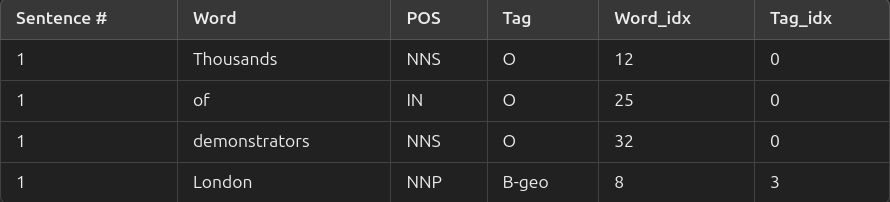

after applying the transformation:

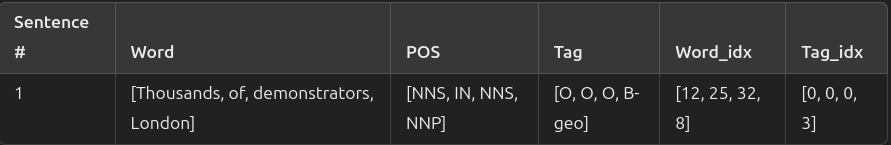

In [11]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )

    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)


train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


In [12]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [14]:
input_dim = len(list(set(data['Word'].to_list())))+1# 1 is added to make an embedding vector for padding in the embedding layer
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

In [15]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.build((None, input_length))
    model.summary()

    return model

In [19]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

In [17]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 104, 64)             │       2,251,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 104, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 104, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 104, 17)             │           1,105 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,368,017 (9.03 MB)

 Trainable params: 2,368,017 (9.03 MB)

 Non-trainable params: 0 (0.00 B)

26/26 ━━━━━━━━━━━━━━━━━━━━ 192s 7s/step - accuracy: 0.0045 - loss: nan - val_accuracy: 4.9005e-05 - val_loss: nan
26/26 ━━━━━━━━━━━━━━━━━━━━ 164s 6s/step - accuracy: 8.1413e-05 - loss: nan - val_accuracy: 4.9005e-05 - val_loss: nan
26/26 ━━━━━━━━━━━━━━━━━━━━ 172s 7s/step - accuracy: 8.1413e-05 - loss: nan - val_accuracy: 4.9005e-05 - val_loss: nan
26/26 ━━━━━━━━━━━━━━━━━━━━ 187s 7s/step - accuracy: 8.1413e-05 - loss: nan - val_accuracy: 4.9005e-05 - val_loss: nan
26/26 ━━━━━━━━━━━━━━━━━━━━ 169s 7s/step - accuracy: 8.1413e-05 - loss: nan - val_accuracy: 4.9005e-05 - val_loss: nan
26/26 ━━━━━━━━━━━━━━━━━━━━ 175s 7s/step - accuracy: 8.1413e-05 - loss: nan - val_accuracy: 4.9005e-05 - val_loss: nan
26/26 ━━━━━━━━━━━━━━━━━━━━ 186s 7s/step - accuracy: 8.1413e-05 - loss: nan - val_accuracy: 4.9005e-05 - val_loss: nan
26/26 ━━━━━━━━━━━━━━━━━━━━ 169s 7s/step - accuracy: 8.1413e-05 - loss: nan - val_accuracy: 4.9005e-05 - val_loss: nan
26/26 ━━━━━━━━━━━━━━━━━━━━ 172s 7s/step - accuracy: 8.1413e-

In [ ]:
val_predictions = model_bilstm_lstm.predict(val_tokens)
val_predictions = np.argmax(val_predictions, axis=-1)  # Get the index of the highest predicted tag
val_predictions_tags = [[idx2tag[idx] for idx in preds if idx != tag2idx["O"]] for preds in val_predictions]
val_true_tags = [[idx2tag[idx] for idx in true if idx != tag2idx["O"]] for true in val_tags]


In [ ]:
from sklearn.metrics import classification_report

# Flatten the lists for sklearn metrics
true_labels = list(chain.from_iterable(val_true_tags))
pred_labels = list(chain.from_iterable(val_predictions_tags))

# Generate classification report
report = classification_report(true_labels, pred_labels, zero_division=0)
print(report)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, pred_labels, labels=list(tag2idx.keys()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(tag2idx.keys()), yticklabels=list(tag2idx.keys()))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('Hi, My name is Aman Kharwal \n I am from India \n I want to work with Google \n Steve Jobs is My Inspiration')
displacy.render(text, style = 'ent', jupyter=True)

In [20]:
text1 = nlp('Apple Inc. was founded on April 1, 1976, in Cupertino, California by Steve Jobs, Steve Wozniak, and Ronald Wayne.')
displacy.render(text1, style='ent', jupyter=True)


In [21]:
text2 = nlp('Elon Musk sold $5 billion worth of Tesla shares in November 2021, which accounted for 10% of his total holdings.')
displacy.render(text2, style='ent', jupyter=True)


In [22]:
text3 = nlp('The conference will be held from 9 AM to 5 PM on March 23, 2024, at the New York Hilton Midtown hotel.Manu will be there')
displacy.render(text3, style='ent', jupyter=True)


In [23]:
text3 = nlp('The conference will be held from 9 AM to 5 PM on March 23, 2024, at the New York Hilton Midtown hotel.')
displacy.render(text3, style='ent', jupyter=True)


In [24]:
text4 = nlp('The 2024 FIFA World Cup will take place in Canada, Mexico, and the United States, with the final match scheduled for July 19, 2024.')
displacy.render(text4, style='ent', jupyter=True)


In [25]:
text5 = nlp('The new iPhone 15 was released in September 2023, and Apple is expected to see a 20% increase in sales this year.')
displacy.render(text5, style='ent', jupyter=True)


In [26]:
text6 = nlp('Jeff Bezos, the founder of Amazon, traveled to space on July 20, 2021, aboard the Blue Origin rocket.')
displacy.render(text6, style='ent', jupyter=True)
